## Import des librairies requises

In [4]:
import os 
import sys
#configuration du chemin d'accès
sys.path.append('/home/onyxia/work')
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
from libsigma import classification as cla
from libsigma.read_and_write import open_image
from libsigma.read_and_write import load_img_as_array
from libsigma.read_and_write import write_image

from libsigma.classification import rasterization
from projet_eval_landes.my_function import rasterisation


## Analyse des échantillons

### Décompte des polygones par classes pour le shp 

In [15]:
gdf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")
gbf = gdf["strate"].value_counts()
print(gbf)

strate
3    121
2     86
4     71
Name: count, dtype: int64


### Décompte des polygones par classes pour le tif 

Commande exécutée :
gdal_rasterize -a strate -tr 10.0 10.0 -te 432950.0 5362770.0 448280.0 5368890.0 -ot Byte -of GTiff -a_nodata 0 -at /home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp /home/onyxia/work/projet_eval_landes/img/vecteur_to_raster.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
strate
3    121
2     86
4     71
Name: count, dtype: int64
Comptage des pixels par classe :
Valeur 2 → 1811 pixels
Valeur 3 → 3094 pixels
Valeur 4 → 2391 pixels


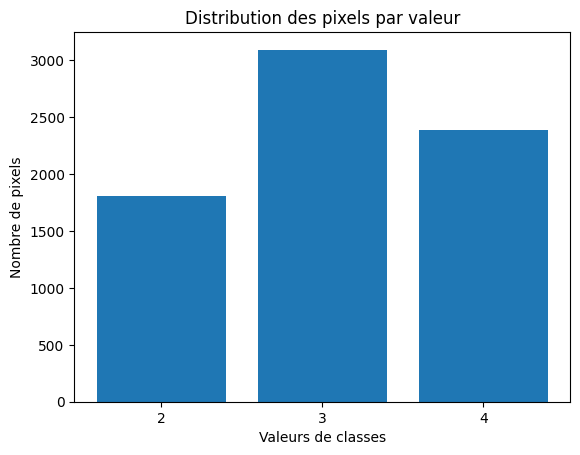

In [16]:
### rasterisation du shp

# création des variables
my_folder = '/home/onyxia/work/data/projet_eval'
in_vector = os.path.join(my_folder, 'PI_strates_bretagne_32630.shp')
ref_image = os.path.join(my_folder, 'bretagne_23-24_B02.tif')
out_image = '/home/onyxia/work/projet_eval_landes/img/vecteur_to_raster.tif'
field_name = "strate"

# création de la fonction de rasterisation 
def rasterisation(in_vector, ref_image, out_image, field_name,
                  dtype="Int32", nodata=0, all_touched=False):

    # --- 1) Lecture des infos spatiales depuis l'image de référence ---
    ds = gdal.Open(ref_image)
    gt = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize

    # résolution (pixel size)
    res_x = gt[1]
    res_y = abs(gt[5])

    # emprise spatiale
    xmin = gt[0]
    ymax = gt[3]
    xmax = xmin + xsize * res_x
    ymin = ymax - ysize * res_y

    # --- 2) Options de GDAL ---
    touched_flag = "-at" if all_touched else ""
    nodata_opt = f"-a_nodata {nodata}" if nodata is not None else ""

    # --- 3) Construction la ligne de commande gdal ---
    cmd = (
        f"gdal_rasterize -a {field_name} "
        f"-tr {res_x} {res_y} "
        f"-te {xmin} {ymin} {xmax} {ymax} "
        f"-ot {dtype} -of GTiff {nodata_opt} {touched_flag} "
        f"{in_vector} {out_image}"
    )

    print("Commande exécutée :")
    print(cmd)

    # --- 4) Exécution ---
    os.system(cmd)

#appel de la fonction 'rasterisation'
rasterisation(in_vector=in_vector, ref_image=ref_image, out_image=out_image, field_name=field_name, dtype="Byte", nodata=0, all_touched=True)

# décompte des pixels par classes pour le tif 
rbf = gpd.read_file("/home/onyxia/work/data/projet_eval/PI_strates_bretagne_32630.shp")
rtf = rbf["strate"].value_counts()
print(rtf)


### mise en place du diagramme en barres 

raster_path = "/home/onyxia/work/projet_eval_landes/img/vecteur_to_raster.tif"

# --- Lecture du raster --- (plutôt utiliser la fonction "load_img_as_array" de 'read_and_write' pour lire et convertir le raster en matrice numpy)
ds = gdal.Open(raster_path)
band = ds.GetRasterBand(1)

arr = band.ReadAsArray()
nodata = band.GetNoDataValue()

# --- Suppression des valeurs NoData ---
if nodata is not None:
    arr = arr[arr != nodata]

# --- Comptage des valeurs ---
values, counts = np.unique(arr, return_counts=True)

print("Comptage des pixels par classe :")
for v, c in zip(values, counts):
    print(f"Valeur {v} → {c} pixels")

# --- Diagramme en barres ---
plt.figure()
plt.bar(values, counts)
plt.xlabel("Valeurs de classes")
plt.ylabel("Nombre de pixels")
plt.title("Distribution des pixels par valeur")
plt.xticks(values)
plt.show()


## Phénologie des strates, mise en évidence des landes

Strates disponibles dans dict_X : dict_keys([np.int32(2), np.int32(3), np.int32(4)])
Strate 2:
  min : -0.06675435
  max : 0.27211457
  mean: 0.14213842
  std : 0.03017945
Strate 3:
  min : -0.111254565
  max : 0.29317266
  mean: 0.13763982
  std : 0.034935467
Strate 4:
  min : -0.08476637
  max : 0.28230277
  mean: 0.10973724
  std : 0.034529414


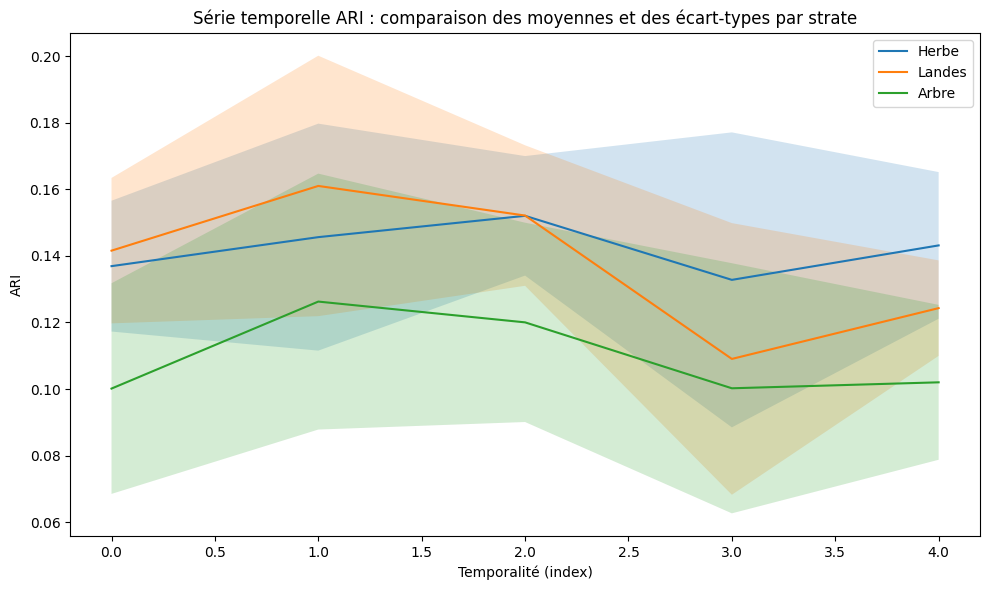

In [12]:
# chargement des images 
data_type_match = {'uint8': gdal.GDT_Byte,
                   'uint16': gdal.GDT_UInt16,
                   'uint32': gdal.GDT_UInt32,
                   'int16': gdal.GDT_Int16,
                   'int32': gdal.GDT_Int32,
                   'float32': gdal.GDT_Float32,
                   'float64': gdal.GDT_Float64}

# define parameters
file_b3 = os.path.join(my_folder, 'bretagne_23-24_B03.tif')
file_b5 = os.path.join(my_folder, 'bretagne_23-24_B05.tif')
out_dirname = '/home/onyxia/work/result'
out_ari_filename = os.path.join(out_dirname, 'ARI_serie_temp.tif')


#load images
data_set_B3 = open_image(file_b3)
img_B3 = load_img_as_array(file_b3)
data_set_B5 = open_image(file_b5)
img_B5 = load_img_as_array(file_b5)


# do some processingwith numpy: compute ndvi
B3 = img_B3[:,:,:].astype('float32')
B5 = img_B5[:,:,:].astype('float32')
ari = (1/B3 - 1/B5) / (1/B3 + 1/B5)

# write it
write_image(out_ari_filename, ari, data_set=data_set_B5,
            gdal_dtype=data_type_match['float32'], projection=None)

# passage du nodata en -9999
ds = gdal.Open(out_ari_filename, gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)   # ou 0, ou ce que tu veux
band.FlushCache()
ds = None


# création des graphiques 
# definition des paramètres

# vers n°2 du graph des moyennes et des écarts-types
dict_X, dict_Y, dict_t = cla.get_samples_from_roi(
    out_ari_filename,       # ton ARI multi-bandes (5 temporalités)
    out_image,         # raster des strates (2..4)
    output_fmt="by_label"
)

print("Strates disponibles dans dict_X :", dict_X.keys())


names = {2:"Herbe", 3:"Landes", 4:"Arbre"}

fig, ax = plt.subplots(figsize=(10, 6)) 

# axe x = temporalités (0..5)
n_dates = dict_X[list(dict_X.keys())[0]].shape[1]
x = np.arange(n_dates)

for lab in sorted(dict_X.keys()):   # lab = 2,3,4
    X = dict_X[lab]                 # (nb_pixels_de_la_strate, nb_dates)
    # Vérification des informations des différentes strates
    print(f"Strate {lab}:")
    print("  min :", np.nanmin(X))
    print("  max :", np.nanmax(X))
    print("  mean:", np.nanmean(X))
    print("  std :", np.nanstd(X))
    
    #mean = X.mean(axis=0)
    #std  = X.std(axis=0)

    #ax.plot(x, mean, label=names.get(lab, f"Strate {lab}"))
    #ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)

    ax.plot(x, mean, label=names.get(int(lab), f"Strate {int(lab)}"))
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

ax.set_xlabel("Temporalité (index)")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle ARI : comparaison des moyennes et des écart-types par strate")
ax.legend()
plt.tight_layout()
plt.show()